# SuperAI Engineer Season 5 Workshop - Transient Signal Classification
Curated by Sanhanat Deesamutara - School of Physics, Institute of Science,SUT
Email - dsanhanat@gmail.com

Backgrounds:
- B.Sc. Computational Physics, Walailak University
- M.Sc. Scientific Computing, Universität Heidelberg

- Full-time Researcher in Astroinformatics, School of Physics, Institute of Science, SUT
- Consider myself a Computational Astrophysicist

## Task: Classifying data whether it consists Pulse, Broad, or Narrow band Signals.
#### What will we learn in this demonstration ?
- Data Inspection
- Data Preprocessing
  - Normalization
  - Class Labeling
  - Image Partitioning
- Example: 4-classes ANN Classifier (Pulse, Broad, Narrow, None)

### Demo files are available on Google Drive
The Link is available at https://drive.google.com/drive/folders/1JwN-qQtZVxkW2--SSYR8XC69k8kiA0Lf?usp=drive_link

To access shared files, please following these steps (Source: StackOverflow)

https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

---

In order to access a shared with you folder or file in Google Colab you have to:

- Go to Shared with me in Google Drive.
- Select the folder or file you want to acess.
- Right click on it and choose Add shortcut to drive.
- A pop-up window will apear, Select MyDrive then click on Add Shortcut.
- Now, Go to your Google Colab Notebook and mount to Google Drive with:
```
from google.colab import drive
drive.mount("/content/gdrive")
```
- Let's suppose you want to access a folder called 'Dataset', you can do this with:

  ```dataset_dir = '/content/gdrive/My Drive/Dataset'```

Now you are ready to access and work on this folder.

In [ ]:
# Let's Start by Importing packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 16

# Newest Version of Pandas returns too much, warning, So I turned it off
pd.set_option("future.no_silent_downcasting", True)

In [ ]:
# Mounting the Google Drive to Colab and Pointing the Path to Dataset
from google.colab import drive
drive.mount("/content/gdrive")
dataset_dir = '/content/gdrive/My Drive/SuperAI-Engineer_Week3_Workshop_Demo_Data'

Mounted at /content/gdrive


In [ ]:
# Here I set the path for Input Spectra and Label

Training_Set_Folder = dataset_dir

X_Training_Files = sorted(glob.glob(Training_Set_Folder + "/*.npy"))
Y_Training_Files = sorted(glob.glob(Training_Set_Folder + "/*.csv"))

## AI in Astronomy Checklist

### 1. Data Inspection

In [ ]:
# Let's Inspect Something by pick up the data for inspection
rec_num = 0
X_demo = np.load(X_Training_Files[rec_num])
Y_demo = pd.read_csv(Y_Training_Files[rec_num])
Y_demo["labels"].value_counts()

,count
labels,
Broad,80
Pulse,9
Broad+Pulse,2


In [ ]:
Y_demo[Y_demo['labels'] == "Broad"]

,Unnamed: 0,index,labels
815,815,815,Broad
840,840,840,Broad
841,841,841,Broad
842,842,842,Broad
843,843,843,Broad
...,...,...,...
916,916,916,Broad
917,917,917,Broad
918,918,918,Broad
919,919,919,Broad


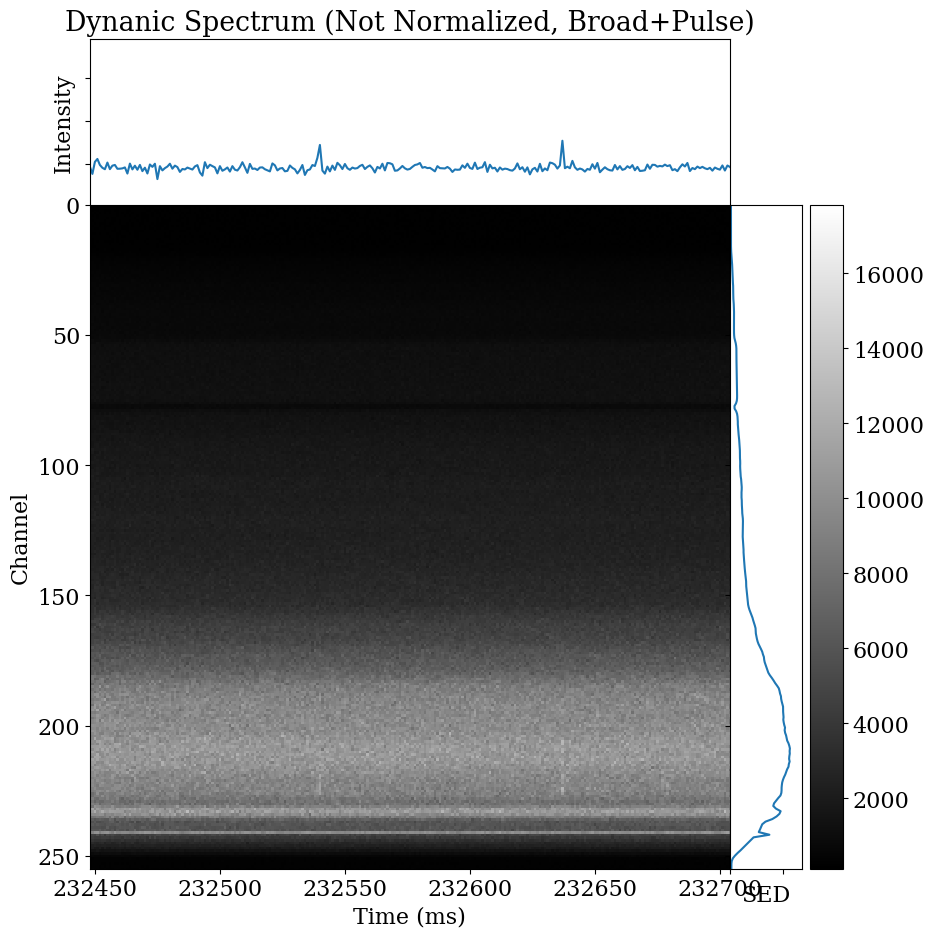

In [ ]:
def make_plot(X_demo, title_string=None, peak = None, vmin=None, vmax=None):
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.93,
                            wspace=0, hspace=0)

    dynanic_spectrum = np.transpose(X_demo)

    ax1 = fig.add_subplot(gs[1, 0])
    heatmap = ax1.imshow(dynanic_spectrum,aspect="auto", origin='upper', interpolation="none", cmap="gray",vmin=vmin,vmax=vmax)
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Channel")
    ax1.set_ylim(dynanic_spectrum.shape[0]-1,0)

    if peak is not False:
        if peak is None:
            peak = np.argmax(np.sum(dynanic_spectrum,axis=0))
        else:
            peak = peak * 256
        offset = 256
        ax1.set_xlim(peak, peak+offset)

    ax2 = fig.add_subplot(gs[1, 1])
    powerspectrum = np.sum(dynanic_spectrum,axis=1)
    freq_bin = np.linspace(0,len(powerspectrum),len(powerspectrum))
    plt.plot(powerspectrum, freq_bin)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.set_xlim(0, 1.2 * np.max(powerspectrum))
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlabel("SED")


    ax3 = fig.add_subplot(gs[0, 0])
    lightcurve = np.sum(dynanic_spectrum,axis=0)
    ax3.plot(lightcurve)
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    #ax3.set_ylim(0, 1.2 * np.max(lightcurve))
    ax3.set_ylabel(r"Intensity")
    if title_string is not None:
        ax3.set_title(title_string)

    fig.colorbar(heatmap, ax=ax2, orientation="vertical",fraction = .5)
    plt.show()

make_plot(X_demo, title_string="Dynanic Spectrum (Not Normalized, Broad+Pulse)", peak=908)

Ligtcurve ~ Variation of Readout data in the temporal domain.

SED ~ Spectral Energy Distribution: illustrating the contribution of power in Each frequency.

### Tips: Do not trust your eyes, your computer can see what you cannot.

Signal can be simply normalized by
$$X_{normalized} =\frac{X_{non-normalized}-Median(X_{non-normalized})}{\sigma_{X_{non-normalized}}}$$

Hence, $X_{normalized}$ is now in scale of Signal-to-Noise ratio.

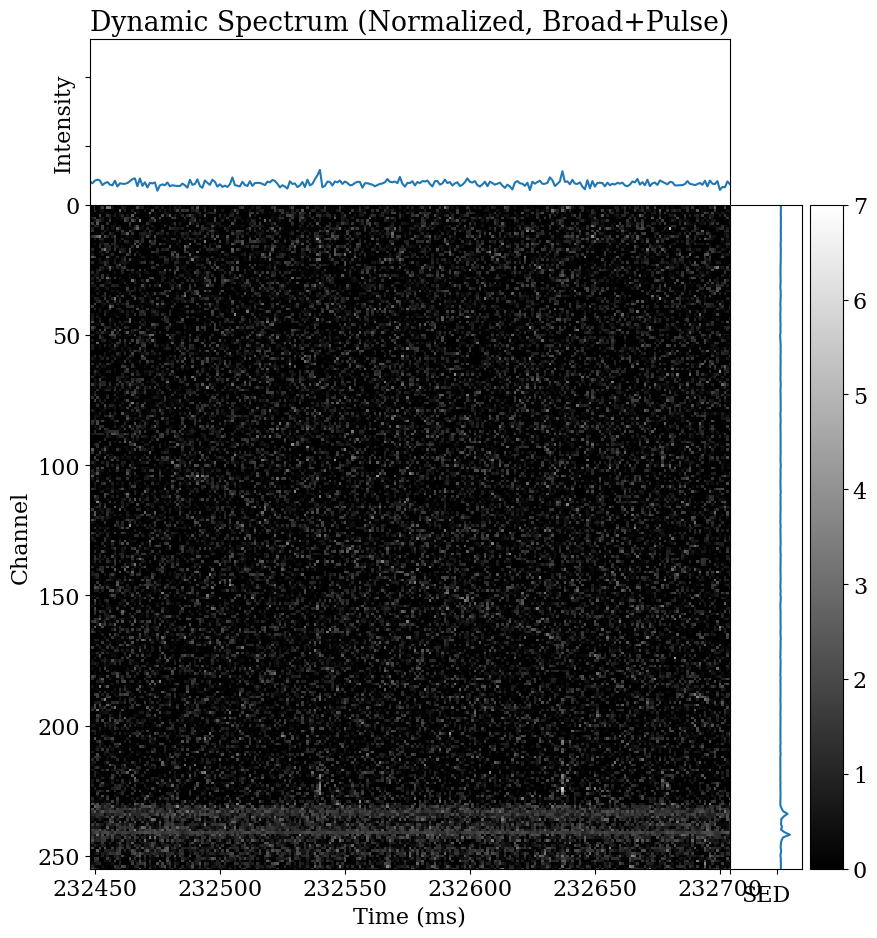

In [ ]:
def snr_normalized(X_demo):
    Dynamic_spectrum = np.transpose(X_demo)
    med = np.median(Dynamic_spectrum, axis=1)
    stdev = np.std(Dynamic_spectrum, axis=1)
    normalized_Dynamic_spectrum = (Dynamic_spectrum.T - med) / stdev
    normalized_Dynamic_spectrum[normalized_Dynamic_spectrum < 0] = 0
    return normalized_Dynamic_spectrum

normalized_Dynamic_spectrum = snr_normalized(X_demo)

make_plot(normalized_Dynamic_spectrum, title_string="Dynamic Spectrum (Normalized, Broad+Pulse)",peak=908,vmin=0, vmax=7)

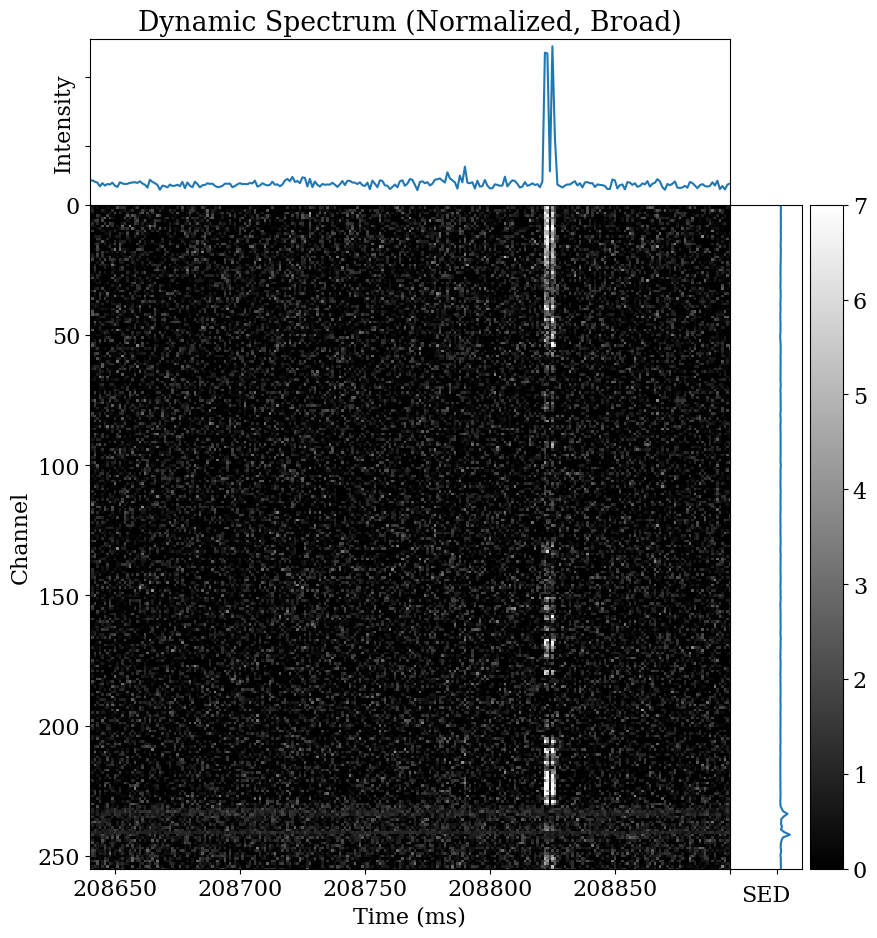

In [ ]:
make_plot(normalized_Dynamic_spectrum, title_string="Dynamic Spectrum (Normalized, Broad)",peak=815, vmin=0, vmax=7)

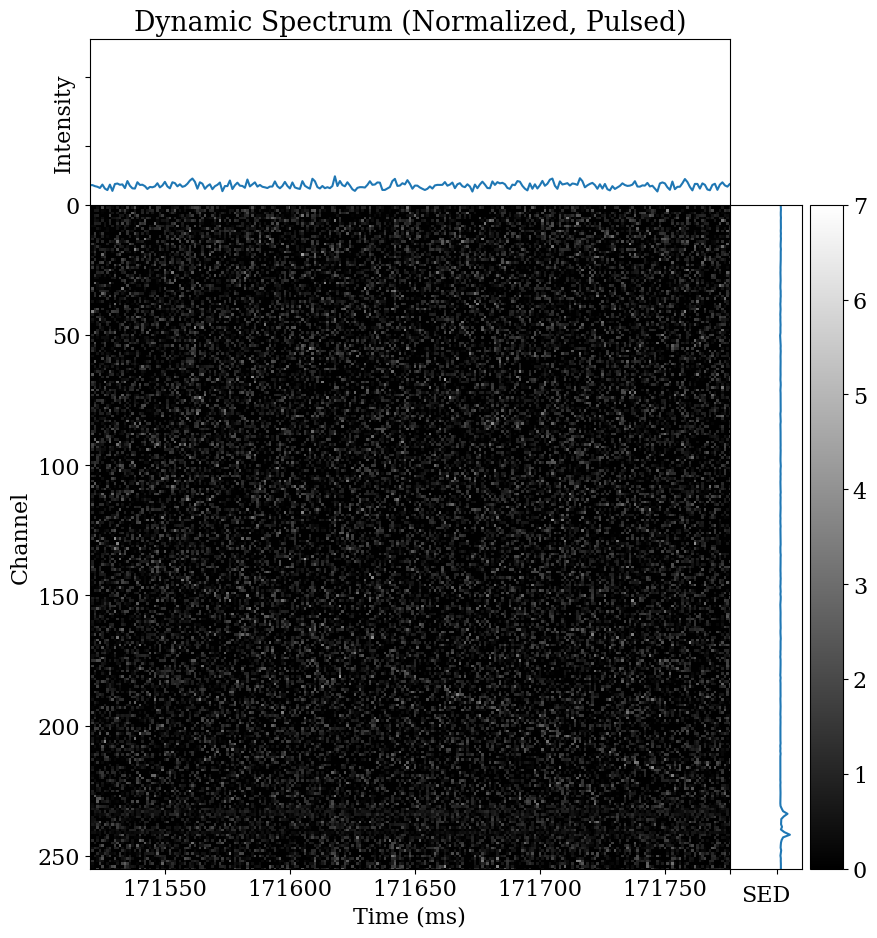

In [ ]:
make_plot(normalized_Dynamic_spectrum, title_string="Dynamic Spectrum (Normalized, Pulsed)",peak=670, vmin=0, vmax=7)

In [ ]:
rec_num = 1
X_demo2 = np.load(X_Training_Files[rec_num])
print("Pulsar label: ", Y_Training_Files[rec_num].split("/")[-1].split(".")[0])
Y_demo2 = pd.read_csv(Y_Training_Files[rec_num])
Y_demo2['labels'].value_counts()

Pulsar label:  B0531+21_58713_43190_reduced_fc_0021503_labels


,count
labels,
Narrow,159
Pulse,9


In [ ]:
Y_demo2[Y_demo2['labels'] == "Narrow"]

,Unnamed: 0,index,labels
865,865,865,Narrow
866,866,866,Narrow
867,867,867,Narrow
868,868,868,Narrow
869,869,869,Narrow
...,...,...,...
1019,1019,1019,Narrow
1020,1020,1020,Narrow
1021,1021,1021,Narrow
1022,1022,1022,Narrow


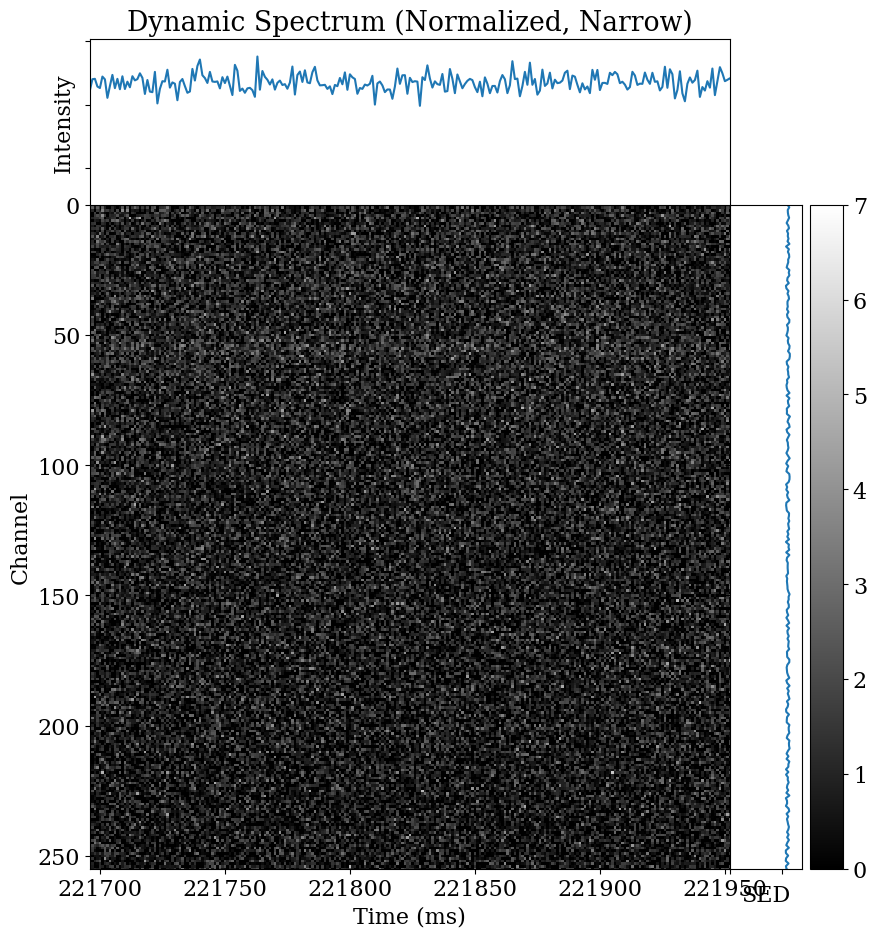

In [ ]:
normalized_Dynamic_spectrum2 = snr_normalized(X_demo2)
make_plot(normalized_Dynamic_spectrum2, title_string="Dynamic Spectrum (Normalized, Narrow)",peak=866,vmin=0, vmax=7)

In [ ]:
rec_num = 2
X_demo3 = np.load(X_Training_Files[rec_num])
print("Pulsar label: ", Y_Training_Files[rec_num].split("/")[-1].split(".")[0])
Y_demo3 = pd.read_csv(Y_Training_Files[rec_num])
Y_demo3['labels'].value_counts()
Y_demo3[Y_demo3['labels'] == "Narrow+Pulse"]

Pulsar label:  B1933+16_59664_23770_reduced_fc_0012047_labels


,Unnamed: 0,index,labels
870,870,870,Narrow+Pulse
871,871,871,Narrow+Pulse
872,872,872,Narrow+Pulse
873,873,873,Narrow+Pulse


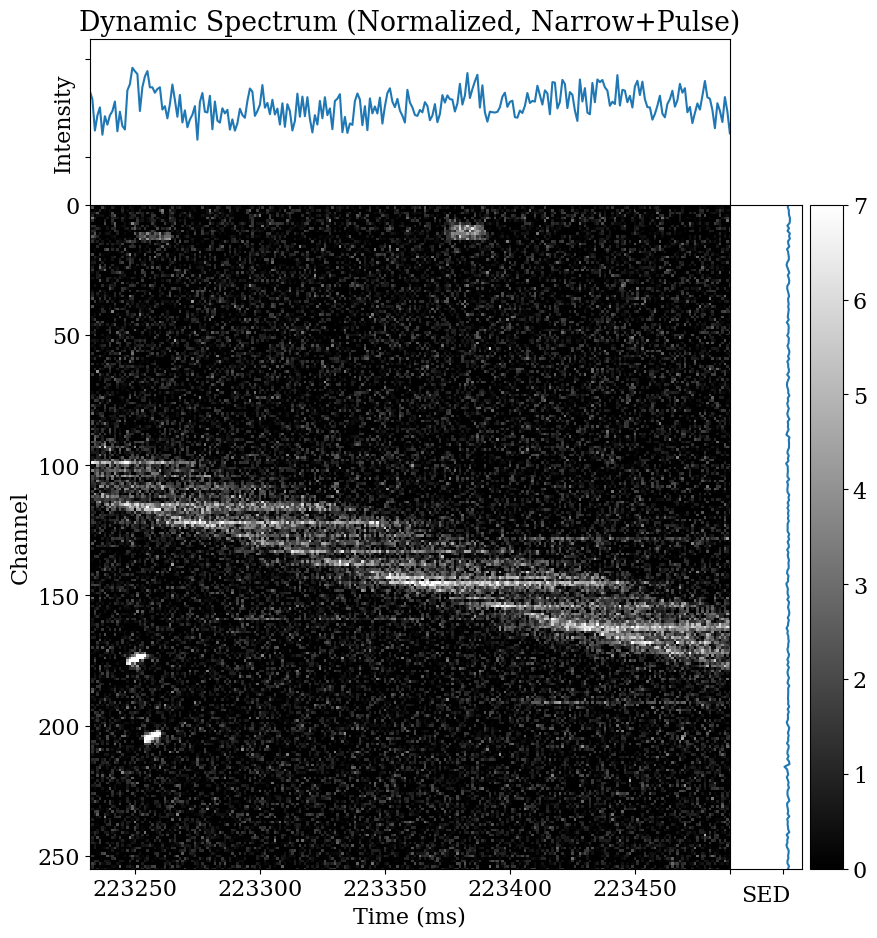

In [ ]:
normalized_Dynamic_spectrum3 = snr_normalized(X_demo3)
make_plot(normalized_Dynamic_spectrum3, title_string="Dynamic Spectrum (Normalized, Narrow+Pulse)",peak=872,vmin=0, vmax=7)

### 3. Use a proper Tool
Using in machine learning model, you might need extra step for preprocessing.

In [ ]:
# Here, we load the target file and replace their labels with class number
Label = []
pop_list = []
for i in tqdm(range(0,len(Y_Training_Files))):
    rec = pd.read_csv(Y_Training_Files[i])
    if len(rec) == 1024:
        labels = rec["labels"].replace(to_replace={np.nan: 0, "Unlabeled":0, "Uncertain":0, "Narrow+Broad":0,"Unknown":0,
                                                    "Pulse": 1,"Unknown+Pulse":1, "Broad+Pulse": 1, "Narrow+Pulse":1,
                                                    "Broad": 2, "Narrow":3}).to_numpy()
        Label.append(labels)
    else:
       pop_list.append(i)

Label = np.array(Label,dtype=np.int32)

100%|██████████| 3/3 [00:00<00:00, 118.95it/s]


In [ ]:
# Counts on unique labels
pd.DataFrame(Label.reshape(-1))[0].value_counts()

,count
0,
0,2582
1,233
3,177
2,80


In [ ]:
# Here, we partitioned each dynamic spectrum to small chunks of images and treated it that way.
X_Training_Files_popped = np.delete(X_Training_Files.copy(),pop_list)
Input = np.empty(shape=(len(X_Training_Files_popped),
                        normalized_Dynamic_spectrum.shape[0]//normalized_Dynamic_spectrum.shape[1],
                        normalized_Dynamic_spectrum.shape[1],
                        normalized_Dynamic_spectrum.shape[1]),dtype=np.float32)

for i in tqdm(range(0,len(X_Training_Files_popped))):
    img = np.load(X_Training_Files_popped[i])
    img = snr_normalized(img)
    img = img.T
    for j in range(0,img.shape[1]//img.shape[0]):
        loc = int(img.shape[0] * j)
        Input[i,j] = img[:,loc:loc+img.shape[0]]

Input = Input.reshape(Input.shape[0]*Input.shape[1],Input.shape[2],Input.shape[3])

100%|██████████| 3/3 [00:16<00:00,  5.39s/it]


### Training Model (Let's use PyTorch simple MLP classifier)
#### <span style="color:Red"> Warning: these code below is adopted from     </span>
- https://nextjournal.com/gkoehler/pytorch-mnist  
- https://ashleyycz.medium.com/mnist-digit-classification-in-pytorch-302476b34e4f

In [ ]:
# Here, just the initialization for torch
n_epochs = 3
batch_size_train = 64
learning_rate = 1e-2
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
# Transform the Numpy arrays to Torch tensor
Input_tensor = torch.from_numpy(Input).reshape(Input.shape[0],1,Input.shape[1],Input.shape[2],) #Input
Target_tensor = torch.from_numpy(Label).reshape(Label.shape[0]*Label.shape[1],1) #Target

In [ ]:
# Define the image classifier model
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(256*256, 512)  # Hidden layer
        self.output = nn.Linear(512, 1)     # Output layer
        #self.sigmoid = nn.Sigmoid()          # Activation function
        self.softmax = nn.LogSoftmax(dim=1)  # Output activation

    def forward(self, x):
        x = self.hidden(x)
        #x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

network = ImageClassifier()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
Loss_func = nn.L1Loss()

In [ ]:
# Make the loader + batch_size for the convenience
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(Input_tensor, Target_tensor),
    batch_size=batch_size_train, shuffle=True)

train_losses = []

In [ ]:
network.train()
for epoch in range(n_epochs):
  running_loss = 0
  for images, labels in tqdm(train_loader):  # Loop over each batch from the dataloader
      images = images.view(images.shape[0], -1)  # Flatten images

      optimizer.zero_grad()  # Zero the gradients
      logits = network(images)  # Forward pass

      logits = logits.squeeze().type(torch.float32)
      labels = labels.squeeze().type(torch.float32)
      loss = Loss_func(logits, labels)  # Calculate loss
      loss.backward()  # Backward pass
      optimizer.step()  # Update weights
      running_loss += loss.item()
  print(f"Epoch {epoch+1}/{n_epochs} - Loss: {running_loss/len(train_loader)}")

  if not os.path.exists('results/'):
    os.makedirs('results/')
  torch.save(network.state_dict(), 'results/model.pth')
  torch.save(optimizer.state_dict(), 'results/optimizer.pth')

100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


Epoch 1/3 - Loss: 0.30078125


100%|██████████| 48/48 [00:41<00:00,  1.15it/s]


Epoch 2/3 - Loss: 0.30078125


100%|██████████| 48/48 [00:41<00:00,  1.15it/s]


Epoch 3/3 - Loss: 0.30078125


In [ ]:
network.load_state_dict(torch.load('results/model.pth',weights_only=False))
optimizer.load_state_dict(torch.load('results/optimizer.pth',weights_only=False))

correct = 0
total = 0
pulse_acc = 0
broad_acc = 0
narrow_acc = 0

with torch.no_grad():
  for images, labels in tqdm(train_loader):  # Loop over each batch from the dataloader
    images = images.view(images.shape[0], -1)  # Flatten images

    optimizer.zero_grad()  # Zero the gradients
    logits = network(images)  # Forward pass

    logits = logits.squeeze().type(torch.float32)
    labels = labels.squeeze().type(torch.float32)
    for i in range(len(logits)):
      if logits[i] == labels[i]:
          correct +=1
          if labels[i] == 1:
             pulse_acc +=1
          if labels[i] == 2:
             broad_acc +=1
          if labels[i] == 3:
             narrow_acc +=1
      total +=1
print('\n'+f'accuracy: {round(correct/total, 3)}')
print(f'Pulse accurate: {round(pulse_acc/total, 3)}')
print(f'Broad accurate: {round(broad_acc/total, 3)}')
print(f'Narrow accurate: {round(narrow_acc/total, 3)}')

100%|██████████| 48/48 [00:05<00:00,  8.77it/s]


accuracy: 0.84
Pulse accurate: 0.0
Broad accurate: 0.0
Narrow accurate: 0.0


### Ah, the result is total (satirically) impressive, but this is just for the motivating reason.
#### There is some points it could be concerned...

- **Class Imbalance:** there is much larger amounts of Class label 0, which means, the model is trained to detect <span style="color:Red">"Nothing"</span> instead of detecting <span style="color:Green">Pulse</span>.

- **Missing Feature:** I just dropped some Dynamic spectrum because is has insuffient number of section, which should not be done. I just want to make it quick. <br> Those dropped features contain bunches of Pulses, which can be used to improve the classifier. You can investigate those dropped spectra later.

- **Preprocessing:** In radio astronomy, you can see that signal is quite weak, as its level is in the similar scale to noise (SNR < 10). You have to concern how to clean data properly without smearing out the features.

- **Probabilistic Prediction:** Similar to MNIST problem, this work can be considered to be multi-labels classification problem.